In [1]:
import pandas as pd
import numpy as np
from sklift.models import ClassTransformation
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import xgboost as xgb

In [6]:
pd.set_option('display.max_columns', 300)
clients = pd.read_csv(r'C:\datasets\retailhero-uplift\data\final_clients1.csv', index_col='client_id')
#clients = pd.read_csv(r'C:\datasets\retailhero-uplift\data\final_clients.csv', index_col='client_id')
uplift_train = pd.read_csv(r'C:\datasets\retailhero-uplift\data\uplift_train.csv', index_col='client_id')
uplift_test = pd.read_csv(r'C:\datasets\retailhero-uplift\data\uplift_test.csv', index_col='client_id')
uplift_sample_submission = pd.read_csv(r'C:\datasets\retailhero-uplift\data\uplift_sample_submission.csv', index_col='client_id')
pd.options.display.max_rows=100
client_index = clients.index

In [3]:
#clients = clients.merge(clients1, left_index=True, right_index=True)

In [7]:
clients

,Unnamed: 0,first_issue_date,first_redeem_date,age,gender,timedelta,transaction_count,purchase_trans_mean,points_received,points_spent,purchase_trans_sum,percent_points,purchase_store_sum,purchase_store_mean,sum_prod_store,mean_prod_store,store_count,product_id,mean_prod_trans
client_id,,,,,,,,,,,,,,,,,,,
000012768d,0,1501947648,1515094207,45,0,13146559,4,700.750000,25.7,0.0,2803.00,0.916875,40809.00,13603.000000,52,17.333333,3,46,13.000000
000036f903,1,1491832463,1492951076,72,1,1118613,32,306.406250,114.9,0.0,9805.00,1.171851,58765.00,11753.000000,162,32.400000,5,96,5.062500
000048b7a6,2,1544880791,0,68,1,0,8,471.500000,26.5,0.0,3772.00,0.702545,29724.00,14862.000000,56,28.000000,2,44,7.000000
000073194a,3,1495544174,1511522281,60,1,15978107,17,564.788235,74.9,96.0,9601.40,0.780095,62719.92,62719.920000,82,82.000000,1,68,4.823529
00007c7133,4,1495469828,1546276653,67,0,50806825,11,610.894545,56.6,240.0,6719.84,0.842282,53998.72,26999.360000,83,41.500000,2,64,7.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffece623e,400157,1526224170,1545937599,67,0,19713429,24,272.083750,38.4,68.0,6530.01,0.588054,43103.46,14367.820000,117,39.000000,3,83,4.875000
ffff3dfff8,400158,1541088412,1544204027,56,1,3115615,17,427.343529,117.9,182.0,7264.84,1.622885,65810.71,65810.710000,96,96.000000,1,86,5.647059
ffffaab9da,400159,1503686604,1512755599,23,1,9068995,7,541.571429,34.0,6.0,3791.00,0.896861,41092.00,41092.000000,60,60.000000,1,53,8.571429


In [8]:
clients.loc[clients['age']>=95, 'age'] = clients['age'].median()
clients.loc[clients['age']<=14, 'age'] = clients['age'].median()
clients.loc[clients['points_received']>=800, 'points_received'] = clients['points_received'].median()
clients.loc[clients['points_spent']>=800, 'points_spent'] = clients['points_spent'].median()
clients.loc[clients['percent_points']>=5, 'percent_points'] = clients['percent_points'].median()

In [9]:
clients['first_issue_date'] = np.log(clients['first_issue_date']+1)
clients['first_redeem_date'] = np.log(clients['first_redeem_date']+1)
clients['timedelta'] = np.log(clients['timedelta']+1)
clients['purchase_trans_mean'] = np.log(clients['purchase_trans_mean']+1)
#clients['points_received'] = np.log(clients['points_received']+1)
#clients['points_spent'] = np.log(clients['points_spent']+1)
clients['purchase_trans_sum'] = np.log(clients['purchase_trans_sum']+1)
#clients['percent_points'] = np.log(clients['percent_points']+1)
clients['purchase_store_sum'] = np.log(clients['purchase_store_sum']+1)
clients['purchase_store_mean'] = np.log(clients['purchase_store_mean']+1)
clients['sum_prod_store'] = np.log(clients['sum_prod_store']+1)
clients['mean_prod_store'] = np.log(clients['sum_prod_store']+1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000009F11588>]],
      dtype=object)

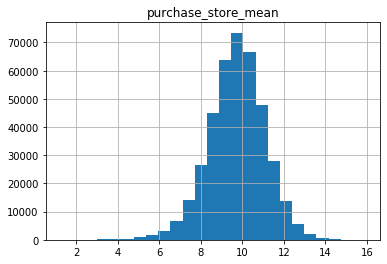

In [10]:
clients.hist('purchase_store_mean', bins=25)

In [11]:
.query('points_received<700')

SyntaxError: invalid syntax (<ipython-input-11-9acd930317d6>, line 1)

In [12]:
clients = clients.drop(['Unnamed: 0'], axis=1)

In [13]:
uplift_train = clients.merge(uplift_train, right_index=True, left_index=True)
#uplift_train = uplift_train[:20000]
uplift_test = clients.merge(uplift_test, right_index=True, left_index=True)
#uplift_test = uplift_test[:20000]
df_features = clients.copy()
indices_train = uplift_train.index
indices_test = uplift_test.index
indices_learn, indices_valid = train_test_split(uplift_train.index, test_size=0.3, random_state=123)

In [14]:
uplift_train

,first_issue_date,first_redeem_date,age,gender,timedelta,transaction_count,purchase_trans_mean,points_received,points_spent,purchase_trans_sum,percent_points,purchase_store_sum,purchase_store_mean,sum_prod_store,mean_prod_store,store_count,product_id,mean_prod_trans,treatment_flg,target
client_id,,,,,,,,,,,,,,,,,,,,
000012768d,21.130029,21.138743,45.0,0,16.391671,4,6.553577,25.7,0.0,7.938802,0.916875,10.616682,9.518119,3.970292,1.603479,3,46,13.000000,0,1
000036f903,21.123271,21.124021,72.0,1,13.927601,32,5.728170,114.9,0.0,9.190750,1.171851,10.981319,9.371949,5.093750,1.807264,5,96,5.062500,1,1
00010925a5,21.150133,21.153060,83.0,0,15.317871,18,5.792505,31.8,17.0,8.679992,0.540541,10.257484,9.564372,4.369448,1.680725,2,58,4.333333,1,1
0001f552b0,21.127964,21.152097,33.0,1,17.415852,15,6.019433,78.9,0.0,8.725212,1.281847,10.778442,9.392211,4.465908,1.698530,4,79,5.733333,1,1
00020e7b18,21.136556,21.139082,73.0,0,15.156729,18,7.269215,286.1,622.0,10.158928,1.108073,13.233854,11.847565,5.609472,1.888504,4,175,15.111111,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,21.136549,21.140884,35.0,1,15.697744,9,5.713153,22.2,176.0,7.907438,0.817252,9.878689,9.185593,3.663562,1.539779,2,36,4.222222,0,0
fffe0ed719,21.132368,21.137420,69.0,0,15.846892,30,5.852919,69.9,0.0,9.251336,0.670988,11.248901,10.555767,5.153292,1.816987,2,89,5.733333,0,1
fffea1204c,21.140276,21.142551,73.0,1,15.055672,17,5.536435,26.1,40.0,8.365933,0.607384,9.888751,9.888751,4.127134,1.634547,1,45,3.588235,0,1


In [15]:
X_train = df_features.loc[indices_learn, :]
y_train = uplift_train.loc[indices_learn, 'target']
treat_train = uplift_train.loc[indices_learn, 'treatment_flg']
X_train_index =  X_train.index

X_val = df_features.loc[indices_valid, :]
y_val = uplift_train.loc[indices_valid, 'target']
treat_val =  uplift_train.loc[indices_valid, 'treatment_flg']
X_val_index =  X_val.index

X_train_full = df_features.loc[indices_train, :]
y_train_full = uplift_train.loc[:, 'target']
treat_train_full = uplift_train.loc[:, 'treatment_flg']
X_train_full_index =  X_train_full.index

X_test = df_features.loc[indices_test, :]
X_test_index =  X_test.index

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [16]:
treat_train_full

client_id
000012768d    0
000036f903    1
00010925a5    1
0001f552b0    1
00020e7b18    1
             ..
fffe0abb97    0
fffe0ed719    0
fffea1204c    0
fffeca6d22    1
fffff6ce77    0
Name: treatment_flg, Length: 200039, dtype: int64

In [17]:
ct = ClassTransformation(GradientBoostingClassifier())
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)
#uplift_ct = ct.estimator.predict_proba(X_val)[:, 1] > 0.6

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

C:\Users\DruzykRB\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


In [30]:
ct_score

0.06426364844859356

In [ ]:
cm_full = ClassTransformation(GradientBoostingClassifier())
cm_full = cm_full.fit(X_train_full, y_train_full, treat_train_full)

X_test.loc[:, 'uplift'] = cm_full.predict(X_test.values)

sub = X_test[['uplift']].to_csv(r'C:\datasets\retailhero-uplift\data\uplift_submission.csv')

In [ ]:
uplift_submission = pd.read_csv(r'C:\datasets\retailhero-uplift\data\uplift_submission.csv')

In [ ]:
uplift_submission.uplift.mean()